# Fashion MNIST

## 1. Data preprocessing

In [30]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, _), (test_x, _) = fashion_mnist.load_data()

이미지 변환 모델 학습 시, 우리는 이미지 자체에 집중합니다. 어떤 카테고리에 속하는지, 어떤 객체가 포함되어 있는지 등의 정보는 중요하지 않습니다. 중요한 것은 이미지 픽셀 값 그 자체입니다.

따라서 load_data() 함수를 사용하여 데이터를 로딩할 때, 레이블 데이터(y_train, y_test에 해당하는 데이터)는 무시하도록 처리해야 합니다. 이때 파이썬에서 변수를 무시할 때 사용하는 기호, 바로 **언더스코어(_)**를 활용합니다.

In [9]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


## 이미지 픽셀 정규화: -1과 1사이 값으로 변환하기

이미지 데이터의 픽셀 값을 정규화하는 방법에 대해 자세히 살펴보겠습니다. 픽셀 값 정규화는 모델의 성능 향상에 중요한 역할을 합니다.

### 왜 픽셀 정규화가 필요할까요?

이미지 픽셀 값은 일반적으로 0부터 255 사이의 값을 가집니다. 이러한 픽셀 값의 범위는 모델 학습에 다음과 같은 문제를 야기할 수 있습니다.

*   **학습 속도 저하:** 픽셀 값의 범위가 넓으면 모델이 최적의 가중치를 찾는데 오랜 시간이 걸릴 수 있습니다.
*   **기울기 소실/폭주:** 신경망 레이어를 통과하면서 기울기가 너무 작아지거나 커져 학습이 제대로 이루어지지 않을 수 있습니다.

따라서 픽셀 값을 정규화하여 0과 1 사이 또는 -1과 1 사이의 값으로 변환함으로써 위와 같은 문제를 해결하고 모델의 성능을 향상시킬 수 있습니다.

### -1과 1사이의 값으로 정규화하는 방법

픽셀 값을 -1과 1 사이의 값으로 정규화하는 방법을 알아보겠습니다. 

**핵심 아이디어:**

1.  **픽셀 값을 0과 1 사이의 값으로 변환:** 픽셀 값을 255로 나누어 0과 1 사이의 값으로 만듭니다.
2.  **값을 -1과 1 사이로 조정:** 0과 1 사이의 값에 2를 곱한 후 1을 빼면 -1과 1 사이의 값으로 변환됩니다.

**코드 예시:**

```python
train_x = (train_x / 255.0) * 2 - 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
```

**코드 설명:**

*   `train_x / 255.0`: 픽셀 값을 0과 1 사이의 값으로 변환합니다. (나누기 연산에 실수 값을 사용해야 정확한 결과를 얻을 수 있습니다.)
*   `* 2 - 1`: 0과 1 사이의 값을 -1과 1 사이의 값으로 조정합니다.

위 코드를 실행하면 픽셀 값이 -1과 1 사이의 값으로 성공적으로 정규화된 것을 확인할 수 있습니다.

**추가 설명:**

*   픽셀 값을 -1과 1 사이로 정규화하는 것은 tanh 활성화 함수를 사용하는 경우에 특히 효과적입니다.
*   데이터셋의 특성에 따라 0과 1 사이로 정규화하는 것이 더 적합할 수도 있습니다.

In [10]:
train_x = (train_x / 255.0) * 2 - 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


## 이미지 데이터, 채널 차원을 추가해야 하는 이유

이미지 픽셀 값을 정규화하여 모델 학습 준비를 마쳤습니다. 이번에는 딥러닝 모델, 특히 CNN(합성곱 신경망) 모델에 이미지를 입력하기 전에 반드시 수행해야 하는 중요한 과정, 바로 **채널 차원 추가**에 대해 자세히 알아보겠습니다.

### 왜 채널 차원을 추가해야 할까요?

이미지 데이터셋을 살펴보면, MNIST 데이터셋의 경우 6만 장의 이미지와 각 이미지의 사이즈가 28x28임을 확인할 수 있습니다. 하지만 이 정보만으로는 딥러닝 모델이 이미지를 제대로 인식할 수 없습니다.

**CNN은 다차원 데이터를 처리합니다.** 특히 이미지를 처리할 때는 가로, 세로, 그리고 채널 정보를 함께 고려해야 합니다. 채널은 이미지의 색상 정보를 나타내는 차원으로, 컬러 이미지의 경우 Red, Green, Blue 세 개의 채널을 가지고, 흑백 이미지의 경우 하나의 채널만 가집니다.

**모델은 입력 데이터의 형태(shape)를 알고 있어야 합니다.** 딥러닝 모델은 학습 데이터의 형태에 맞춰 설계됩니다. 따라서 모델에 이미지를 입력하기 전에 데이터의 형태를 모델이 이해할 수 있도록 맞춰줘야 합니다.

### Fashion MNIST, 채널 수는 얼마일까요?

Fashion MNIST 데이터셋은 흑백 이미지로 구성되어 있습니다. 흑백 이미지는 하나의 채널만 가지므로, 채널 수는 1입니다.

### 채널 차원 추가, 어떻게 할까요?

이미지 데이터셋의 shape 마지막에 1을 추가하여 채널 차원을 추가할 수 있습니다. 

**코드 예시 (TensorFlow/Keras):**

```python
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

print("train_x shape:", train_x.shape)
print("test_x shape:", test_x.shape)
```

**코드 설명:**

*   `train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)`: `train_x`의 형태를 (이미지 개수, 가로, 세로, 채널)로 변경합니다. 
    *   `train_x.shape[0]`: 이미지 개수
    *   `train_x.shape[1]`: 이미지 가로 크기
    *   `train_x.shape[2]`: 이미지 세로 크기
    *   `1`: 채널 수 (흑백 이미지이므로 1)
*   `test_x.reshape(...)`: `test_x`에 대해서도 동일한 작업을 수행합니다.

위 코드를 실행하면 `train_x`와 `test_x`의 shape 마지막에 1이 추가된 것을 확인할 수 있습니다. 예를 들어, `train_x`의 shape가 (60000, 28, 28)에서 (60000, 28, 28, 1)로 변경됩니다.

In [13]:
train_x.shape

(60000, 28, 28)

In [14]:
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

print("train_x shape:", train_x.shape)
print("test_x shape:", test_x.shape)

train_x shape: (60000, 28, 28, 1)
test_x shape: (10000, 28, 28, 1)


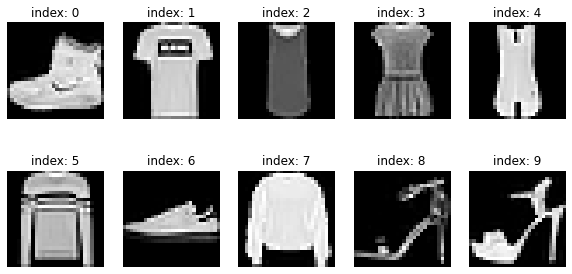

In [16]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## 2. Model Training

## 효율적인 모델 학습을 위한 데이터셋 구축: tf.data.Dataset 완벽 가이드

전처리된 데이터를 딥러닝 모델에 효율적으로 공급하기 위한 핵심 도구, `tf.data.Dataset`에 대해 자세히 살펴보겠습니다.

### 왜 tf.data.Dataset을 사용해야 할까요?

딥러닝 모델 학습은 막대한 양의 데이터를 처리해야 합니다. 이러한 데이터를 효율적으로 관리하고 모델에 공급하기 위해 TensorFlow는 `tf.data.Dataset`이라는 강력한 API를 제공합니다. `tf.data.Dataset`을 사용하면 다음과 같은 장점을 얻을 수 있습니다.

*   **메모리 효율성:** 대용량 데이터를 메모리에 한 번에 로드하지 않고 필요한 만큼만 읽어 처리하여 메모리 사용량을 줄입니다.
*   **병렬 처리:** 데이터 로딩, 변환, 전처리 등을 병렬로 처리하여 학습 속도를 향상시킵니다.
*   **유연성:** 다양한 데이터 소스(이미지, 텍스트, CSV 파일 등)로부터 데이터를 로드하고 변환할 수 있습니다.

### tf.data.Dataset 핵심 기능: 셔플링(Shuffling)과 배치(Batching)

이번 포스팅에서는 `tf.data.Dataset`의 가장 중요한 두 가지 기능, 셔플링(Shuffling)과 배치(Batching)에 대해 집중적으로 알아보겠습니다.

#### 1. 셔플링(Shuffling): 데이터 순서 섞기

**왜 셔플링이 필요할까요?** 모델이 학습 데이터의 순서에 과도하게 의존하는 것을 방지하고, 다양한 패턴을 학습할 수 있도록 데이터셋을 무작위로 섞는 과정이 필요합니다. 

**셔플링 방법:** `tf.data.Dataset.shuffle()` 함수를 사용하여 데이터셋을 섞을 수 있습니다.

```python
BUFFER_SIZE = 60000  # 전체 데이터셋 크기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE)
```

**코드 설명:**

*   `BUFFER_SIZE`: 셔플링을 위한 버퍼 크기를 설정합니다. 버퍼 크기가 클수록 데이터가 더 잘 섞이지만, 메모리 사용량도 증가합니다. 일반적으로 버퍼 크기는 전체 데이터셋 크기와 같거나 크게 설정하는 것이 좋습니다.
*   `tf.data.Dataset.from_tensor_slices(train_x)`: NumPy 배열 `train_x`로부터 데이터셋을 생성합니다.
*   `.shuffle(BUFFER_SIZE)`: 데이터셋을 `BUFFER_SIZE`만큼 섞습니다.

#### 2. 배치(Batching): 미니 배치 학습

**왜 배치 학습을 해야 할까요?** 전체 데이터를 한 번에 모델에 입력하는 것보다 작은 묶음(미니 배치)으로 나누어 학습하는 것이 더 효율적입니다.

*   **메모리 효율성:** 전체 데이터를 메모리에 한 번에 로드하지 않아 메모리 부족 문제를 해결합니다.
*   **학습 속도 향상:** 작은 데이터 묶음으로 학습하여 가중치 업데이트 빈도를 높이고 학습 속도를 향상시킵니다.
*   **일반화 성능 향상:** 미니 배치 학습은 모델이 특정 데이터에 과적합되는 것을 방지하고 일반화 성능을 향상시키는 데 도움이 됩니다.

**배치 방법:** `tf.data.Dataset.batch()` 함수를 사용하여 데이터셋을 배치로 나눌 수 있습니다.

```python
BATCH_SIZE = 256  # 배치 크기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
```

**코드 설명:**

*   `BATCH_SIZE`: 한 번에 모델에 입력할 데이터의 개수를 설정합니다.
*   `.batch(BATCH_SIZE)`: 데이터셋을 `BATCH_SIZE` 크기의 배치로 나눕니다.

#### 최종 코드

```python
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
```

In [18]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## GAN(Generative Adversarial Network)

딥러닝 기반 생성 모델 중 가장 혁신적인 아이디어로 손꼽히는 GAN(Generative Adversarial Network)에 대해 자세히 알아보겠습니다. 2014년 Ian Goodfellow에 의해 처음 소개된 GAN은 독특하고 직관적인 구조 덕분에 발표 이후 현재까지도 활발한 연구가 진행되고 있습니다.

### GAN이란 무엇일까요?

GAN은 **Generative Adversarial Network**, 즉 **생성적 적대 신경망**의 약자로, 이름에서 알 수 있듯이 **생성자(Generator)**와 **판별자(Discriminator)**라는 두 개의 네트워크가 서로 경쟁하며 학습하는 구조를 가집니다.

**생성자(Generator):** 아무 의미 없는 랜덤 노이즈를 입력받아 신경망 연산을 통해 실제와 같은 이미지 형상의 벡터를 생성합니다. 마치 **무에서 유를 창조**하는 것과 같은 역할을 수행합니다.

**판별자(Discriminator):** 기존에 있던 진짜 이미지와 생성자가 만들어낸 가짜 이미지를 입력받아 각 이미지가 진짜(Real)인지 가짜(Fake)인지 판단합니다. 판별자는 판단 정도를 실숫값으로 출력합니다.

### 위조지폐범과 경찰의 비유: GAN의 핵심 아이디어

Ian Goodfellow는 GAN을 처음 발표했을 때, 생성자와 판별자를 각각 **위조지폐를 만들어내는 팀**과 **위조지폐범을 잡아내는 경찰**에 비유했습니다.

*   **위조지폐범 (Generative Model):** 최대한 진짜와 똑같은 위조지폐를 만들어내 경찰을 속이려고 노력합니다.
*   **경찰 (Discriminative Model):** 진짜 지폐와 위조지폐를 구분하는 능력을 키워 위조지폐범을 잡으려고 노력합니다.

이러한 경쟁 과정 속에서 위조지폐범은 더욱 정교한 위조지폐를 만들게 되고, 경찰은 더욱 뛰어난 감별 능력을 갖추게 됩니다.

### GAN의 학습 목표: 완벽한 위조지폐 만들기

위조지폐범과 경찰의 경쟁은 끊임없이 서로를 성장하게 만들고, 궁극적으로 **진짜 지폐와 구분할 수 없는 완벽한 위조지폐**를 만들어내는 것을 목표로 합니다. 즉, **생성자가 생성한 이미지가 판별자를 완벽하게 속일 수 있도록** 학습하는 것이 GAN의 목표입니다.

이렇게 서로 적대적인 관계를 통해 모델을 학습하는 구조 덕분에 이름에 "Adversarial(적대적인)"이 들어가게 된 것입니다.

### DCGAN (Deep Convolutional GAN): 합성곱 층을 활용한 GAN

특히 GAN 중 합성곱 층(Convolutional Layer)으로 이루어진 딥러닝 모델을 **DCGAN (Deep Convolutional GAN)**이라고 합니다.

DCGAN은 **균등 분포에서 추출한 100개의 랜덤 숫자(코드 또는 잠재 변수라고 함)**를 입력받아 **이미지(예: 64x64x3 이미지)**를 출력합니다.

### GAN 외의 다른 생성 모델링 기법

GAN 외에도 다양한 생성 모델링 기법이 존재합니다. 대표적인 예로는 다음과 같은 모델들이 있습니다.

*   **Variational Autoencoders (VAEs)**
*   **Autoregressive models (ex. Pixel RNN)**

## DCGAN 생성자 모델 구현 및 이미지 생성

Keras Sequential API를 활용하여 DCGAN의 핵심 구성 요소인 **생성자(Generator) 모델**을 직접 구현하고, 랜덤 노이즈를 사용하여 가짜 이미지를 생성해 보겠습니다.

### 생성자 모델 구현: 코드 따라하기

In [19]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Second: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# 생성자 모델 생성
generator = make_generator_model()

# 모델 요약 정보 출력
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

1.  **`make_generator_model()` 함수 정의:** 생성자 모델을 생성하는 함수를 정의합니다.
2.  **`tf.keras.Sequential()`:** Keras Sequential API를 사용하여 모델을 시작합니다.
3.  **`Dense Layer`:** 100차원의 랜덤 노이즈 벡터를 입력받아 `7*7*256` 크기의 벡터로 변환합니다.
    *   `input_shape=(100,)`: 입력 벡터의 형태를 100차원으로 설정합니다.
4.  **`Reshape Layer`:** 벡터를 (7, 7, 256) 형태의 3차원 텐서로 변환합니다.
5.  **`Conv2DTranspose Layers`:** `Conv2DTranspose` 층은 일반적인 `Conv2D` 층과 반대로 이미지 사이즈를 넓혀주는 층입니다. 모델에서는 세 번의 `Conv2DTranspose` 층을 이용하여 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지 크기를 키워나갑니다. 최종 사이즈 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일합니다.
    *   `kernel_size=(5, 5)`: 커널 크기를 5x5로 설정합니다.
    *   `strides=(2, 2)`: 스트라이드를 2x2로 설정하여 이미지 크기를 두 배로 늘립니다.
    *   `padding='same'` : 입력과 출력 이미지의 크기가 동일하도록 패딩을 설정합니다.
6.  **`BatchNormalization Layer`:** 각 레이어의 가중치가 폭발하지 않도록 가중치 값을 정규화합니다.
7.  **`LeakyReLU Activation Function`:** 중간층의 활성화 함수로 `LeakyReLU`를 사용합니다.
8.  **`tanh Activation Function`:** 마지막 층의 활성화 함수로 `tanh`를 사용합니다. 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

### 생성된 이미지 확인

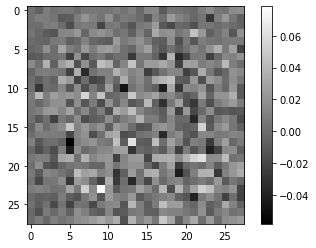

In [20]:
# 랜덤 노이즈 생성 (shape=(1, 100))
noise = tf.random.normal([1, 100])

# 생성자 모델에 랜덤 노이즈 입력하여 가짜 이미지 생성
generated_image = generator(noise, training=False)

# 생성된 이미지 시각화
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

**코드 설명:**

1.  **`tf.random.normal([1, 100])`:** 가우시안 분포에서 추출한 랜덤 벡터로 이루어진 노이즈 벡터를 생성합니다.
2.  **`generator(noise, training=False)`:** 생성자 모델에 노이즈 벡터를 입력하여 가짜 이미지를 생성합니다.
    *   `training=False`: 모델이 학습 모드가 아님을 명시합니다. `BatchNormalization` 레이어는 훈련 시기와 추론(inference) 시기의 행동이 다르기 때문에 `training=False`을 주어야 올바른 결과를 얻을 수 있습니다.
3.  **`plt.imshow(...)`:** 생성된 이미지를 시각화합니다.
    *   `generated_image[0, :, :, 0]`: `matplotlib` 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정하여 (28, 28) shape의 이미지를 꺼냅니다.
    *   `cmap='gray'`: 흑백 이미지로 표시합니다.

### 생성된 이미지 확인 및 해석

아직 모델이 학습되지 않았기 때문에 생성된 이미지는 의미 없는 노이즈처럼 보일 것입니다. 하지만 위 코드를 통해 생성자 모델이 정상적으로 작동하고, 랜덤 노이즈를 입력받아 (28, 28) 크기의 이미지를 생성하는 것을 확인할 수 있습니다.

## DCGAN 판별자 모델 구현: 진짜와 가짜를 구별하는 눈

이전 포스팅에서는 DCGAN의 생성자 모델을 구현하고 가짜 이미지를 생성하는 방법에 대해 알아보았습니다. 이번 포스팅에서는 DCGAN의 또 다른 핵심 구성 요소인 **판별자(Discriminator) 모델**을 구현하고, 생성된 가짜 이미지를 판별해 보겠습니다.

### 판별자 모델 구현: 코드 따라하기

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

# 판별자 모델 생성
discriminator = make_discriminator_model()

# 모델 요약 정보 출력
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

**코드 설명:**

1.  **`make_discriminator_model()` 함수 정의:** 판별자 모델을 생성하는 함수를 정의합니다.
2.  **`tf.keras.Sequential()`:** Keras Sequential API를 사용하여 모델을 시작합니다.
3.  **`Conv2D Layers`:** `Conv2D` 층을 사용하여 이미지의 특징을 추출하고 크기를 줄여나갑니다.
    *   `filters`: 필터의 개수를 지정합니다. 첫 번째 `Conv2D` 층에서는 64개의 필터를 사용하고, 두 번째 `Conv2D` 층에서는 128개의 필터를 사용합니다.
    *   `(5, 5)`: 커널 크기를 5x5로 설정합니다.
    *   `strides=(2, 2)`: 스트라이드를 2x2로 설정하여 이미지 크기를 절반으로 줄입니다.
    *   `padding='same'` : 입력과 출력 이미지의 크기가 동일하도록 패딩을 설정합니다.
    *   `input_shape=[28, 28, 1]`: 입력 이미지의 크기를 (28, 28, 1)로 설정합니다. (첫 번째 `Conv2D` 층에서만 입력 크기를 지정합니다.)
    *   `LeakyReLU()`: Leaky ReLU 활성화 함수를 사용합니다.
    *   `Dropout(0.3)`: 과적합을 방지하기 위해 드롭아웃 레이어를 추가합니다. 드롭아웃 비율은 0.3으로 설정합니다.
4.  **`Flatten Layer`:** 3차원 텐서를 1차원 벡터로 펼칩니다. 생성자의 `Reshape` 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다.
5.  **`Dense Layer`:** 마지막 `Dense` 레이어를 거쳐 단 하나의 값을 출력합니다. 이 값은 입력 이미지가 진짜라고 판단하는 정도를 나타냅니다.

### 가짜 이미지 판별

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

# 판별자 모델 생성
discriminator = make_discriminator_model()

# 모델 요약 정보 출력
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

**코드 설명:**

*   `discriminator(generated_image, training=False)`: 판별자 모델에 가짜 이미지를 입력하여 판별 결과를 얻습니다.
    *   `training=False`: 모델이 학습 모드가 아님을 명시합니다.

### 판별 결과 확인 및 해석

아직 모델이 학습되지 않았기 때문에 판별 결과는 큰 의미가 없을 것입니다. 하지만 위 코드를 통해 판별자 모델이 정상적으로 작동하고, 가짜 이미지를 입력받아 판별 결과를 출력하는 것을 확인할 수 있습니다.

## DCGAN 손실 함수 및 최적화 함수 설정: 생성자와 판별자의 경쟁 심화

이전 포스팅에서는 DCGAN의 생성자와 판별자 모델을 구현했습니다. 이제 모델 학습을 위한 핵심 요소, **손실 함수(loss function)**와 **최적화 함수(optimizer)**를 설정하고, 학습 과정을 모니터링하기 위한 준비를 진행하겠습니다.

### 손실 함수(Loss Function): 목표 달성을 위한 지표

GAN은 생성자와 판별자가 서로 경쟁하며 학습하는 구조이므로, 각 네트워크의 목표에 맞는 손실 함수를 설계해야 합니다. 이번에는 **교차 엔트로피(Cross Entropy)**를 손실 함수로 사용합니다.

#### 교차 엔트로피(Cross Entropy)

교차 엔트로피는 두 확률 분포 간의 차이를 측정하는 데 사용되는 함수입니다. 분류 모델에서 많이 사용되며, 두 값의 차이를 정량적으로 계산하는 데 유용합니다. 특히 판별자는 이미지의 진위를 판별하는 이진 분류 문제를 해결해야 하므로, **이진 교차 엔트로피(Binary Cross Entropy)**를 사용합니다.

#### 생성자와 판별자의 목표

*   **생성자(Generator):** 생성한 가짜 이미지(Fake Image)를 판별자가 진짜(Real)라고 판단하도록 속이는 것이 목표입니다. 즉, 판별자가 Fake Image에 대해 판별한 값 `D(fake_image)`가 1에 가까워지도록 학습해야 합니다.
*   **판별자(Discriminator):** 진짜 이미지(Real Image)는 진짜로, 가짜 이미지(Fake Image)는 가짜로 정확하게 판별하는 것이 목표입니다. 즉, `D(real_image)`는 1에, `D(fake_image)`는 0에 가까워지도록 학습해야 합니다.

#### 손실 함수 구현

In [23]:
# 교차 엔트로피 손실 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자 손실 함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 판별자 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 판별자 정확도 계산 함수
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

**코드 설명:**

1.  **`tf.keras.losses.BinaryCrossentropy(from_logits=True)`:** 이진 교차 엔트로피 손실 함수를 정의합니다. `from_logits=True`는 판별자의 마지막 레이어에 활성화 함수(sigmoid)가 없으므로, 입력 값을 0과 1 사이로 정규화하기 위해 설정합니다.
2.  **`generator_loss(fake_output)`:** 생성자의 손실 함수를 정의합니다. 판별자가 Fake Image에 대해 판별한 값 `fake_output`이 1에 가까워지도록 학습합니다.
3.  **`discriminator_loss(real_output, fake_output)`:** 판별자의 손실 함수를 정의합니다. Real Image에 대한 판별 값 `real_output`은 1에, Fake Image에 대한 판별 값 `fake_output`은 0에 가까워지도록 학습합니다.
4.  **`discriminator_accuracy(real_output, fake_output)`:** 판별자의 정확도를 계산하는 함수를 정의합니다. Real Image와 Fake Image에 대한 정확도를 각각 계산하여 반환합니다.

### 판별자 정확도(Discriminator Accuracy) 모니터링의 중요성

판별자의 정확도는 GAN 학습 과정에서 매우 중요한 지표입니다.

*   **높은 정확도 (1.0에 가까운 값):** 판별자가 Real Image와 Fake Image를 매우 쉽게 구별한다는 의미입니다. 이는 생성자가 생성하는 이미지가 Real Image와 차이가 크다는 것을 나타냅니다.
*   **낮은 정확도 (0.5에 가까운 값):** 판별자가 Real Image와 Fake Image를 구별하기 어려워한다는 의미입니다. 이는 생성자가 생성하는 이미지가 Real Image와 매우 유사해졌다는 것을 나타냅니다.

GAN 학습의 이상적인 시나리오는 **초반에는 높은 정확도를 보이다가 점차 낮아져 0.5에 가까워지는 것**입니다.

### 최적화 함수(Optimizer): 가중치 업데이트 전략

손실 함수를 정의했다면, 이제 손실 함수를 최소화하기 위한 최적화 알고리즘을 선택해야 합니다. 이번에는 **Adam Optimizer**를 사용합니다.

#### Adam Optimizer

Adam은 딥러닝 모델 학습에 널리 사용되는 최적화 알고리즘 중 하나입니다. Adaptive Moment Estimation의 약자로, 경사하강법의 단점을 보완하고 학습 속도와 성능을 향상시키는 데 효과적입니다.

#### 최적화 함수 설정

In [24]:
# 생성자 최적화 함수
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 판별자 최적화 함수
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**코드 설명:**

*   `tf.keras.optimizers.Adam(1e-4)`: Adam Optimizer를 생성합니다. `learning_rate`는 0.0001로 설정합니다. 학습 품질을 향상시키려면 다양한 `learning_rate` 값을 시도해 보세요.
*   **생성자와 판별자는 서로 다른 네트워크이므로, 최적화 함수를 각각 따로 생성해야 합니다.**

### 학습 과정 모니터링: 고정된 Seed 노이즈 생성

GAN 학습 과정을 시각적으로 확인하기 위해 생성자가 생성한 샘플 이미지를 주기적으로 확인할 것입니다. 샘플 이미지를 생성할 때마다 동일한 노이즈를 사용하면 학습 진행 상황을 일관성 있게 추적할 수 있습니다.

In [25]:
# 생성할 샘플 이미지 개수
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 생성할 샘플 이미지 개수
num_examples_to_generate = 16

# 고정된 seed 노이즈 생성 (16개, 100차원)
seed = tf.random.normal([num_examples_to_generate, 100])

**코드 설명:**

*   `num_examples_to_generate = 16`: 생성할 샘플 이미지 개수를 16개로 설정합니다.
*   `tf.random.normal([num_examples_to_generate, 100])`: 100차원 노이즈 벡터를 16개 생성합니다. 이렇게 생성된 `seed`는 학습 과정에서 고정된 값으로 사용됩니다.

## DCGAN 학습 과정 설계: 효율적인 훈련과정 및 결과 시각화

이전 포스팅에서는 DCGAN의 손실 함수와 최적화 함수를 설정하고, 학습 과정 모니터링을 위한 준비를 마쳤습니다. 이번 포스팅에서는 본격적인 학습을 위한 `train_step` 함수를 정의하고, 학습 과정을 시각화하여 모델의 성능 향상을 효과적으로 추적할 수 있도록 훈련 과정 설계를 진행하겠습니다.

### 1. `train_step` 함수 정의: 미니 배치 학습

`train_step` 함수는 **하나의 미니 배치**에 대한 학습 과정을 수행하는 핵심 함수입니다. 텐서플로우 2.0부터는 `@tf.function` 데코레이터를 사용하여 세션을 직접 관리할 필요 없이 효율적인 학습을 수행할 수 있습니다.

In [26]:
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])  # (2) 생성자 입력 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # (3) GradientTape 시작
        generated_images = generator(noise, training=True)  # (4) 가짜 이미지 생성

        real_output = discriminator(images, training=True)  # (5) 진짜 이미지 판별
        fake_output = discriminator(generated_images, training=True)  # (5) 가짜 이미지 판별

        gen_loss = generator_loss(fake_output)  # (6) 생성자 손실 계산
        disc_loss = discriminator_loss(real_output, fake_output)  # (6) 판별자 손실 계산

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)  # (7) 판별자 정확도 계산

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  # (8) 생성자 Gradient 계산
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # (8) 판별자 Gradient 계산

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # (9) 생성자 가중치 갱신
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # (9) 판별자 가중치 갱신

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # (10) 결과 반환

**코드 설명:**

1.  **입력 데이터:** `images` (Real Image)를 입력으로 받습니다.
2.  **생성자 입력 노이즈 생성:** `tf.random.normal`을 사용하여 생성자가 가짜 이미지를 생성하기 위한 랜덤 노이즈를 생성합니다. 노이즈의 크기는 `images`의 배치 크기와 동일하게 설정합니다.
3.  **`tf.GradientTape()`:** 자동 미분 기능을 사용하여 가중치 갱신을 위한 Gradient를 계산합니다.
4.  **가짜 이미지 생성:** `generator`에 노이즈를 입력하여 가짜 이미지 `generated_images`를 생성합니다.
5.  **판별:** `discriminator`에 Real Image(`images`)와 Fake Image(`generated_images`)를 각각 입력하여 `real_output`과 `fake_output`을 출력합니다.
6.  **손실 계산:** `fake_output`과 `real_output`을 사용하여 생성자와 판별자의 손실을 각각 계산합니다.
7.  **정확도 계산:** `fake_output`과 `real_output`을 사용하여 판별자의 정확도를 계산합니다.
8.  **Gradient 계산:** `gen_tape`와 `disc_tape`를 사용하여 생성자와 판별자의 Gradient를 자동으로 계산합니다.
9.  **모델 학습:** 계산된 Gradient를 `optimizer`에 입력하여 생성자와 판별자의 가중치를 갱신합니다.
10. **결과 반환:** 이번 스텝에 계산된 손실과 정확도를 반환합니다.

#### `@tf.function` 데코레이터

`@tf.function` 데코레이터는 함수를 **TensorFlow 그래프**로 컴파일하여 실행 속도를 향상시킵니다. 데코레이터가 적용된 함수에 입력된 데이터는 TensorFlow 그래프 노드가 될 수 있는 타입으로 자동 변환됩니다.

### 2. `generate_and_save_images` 함수 정의: 샘플 이미지 생성 및 저장

`generate_and_save_images` 함수는 학습 과정 중에 생성자가 생성한 샘플 이미지를 시각화하고 저장하여 학습 진행 상황을 모니터링하는 데 사용됩니다.

In [27]:
def generate_and_save_images(model, epoch, it, seed):
    predictions = model(seed, training=False)  # (1) 예측

    fig = plt.figure(figsize=(4, 4))  # (2) 플롯 생성
    for i in range(predictions.shape[0]):  # (3) 16개 이미지 시각화
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))  # (4) 이미지 저장

    plt.show()  # (5) 이미지 출력

**코드 설명:**

1.  **예측:** `model`에 고정된 `seed`를 입력하여 가짜 이미지를 생성합니다. `training=False`를 설정하여 추론 모드로 실행합니다.
2.  **플롯 생성:** `matplotlib`을 사용하여 4x4 크기의 플롯을 생성합니다.
3.  **이미지 시각화:** 플롯에 16개의 이미지를 시각화합니다. `plt.imshow`를 사용하여 각 이미지를 흑백으로 표시하고, 축을 숨깁니다.
4.  **이미지 저장:** `plt.savefig`를 사용하여 생성된 이미지를 파일로 저장합니다. 파일 이름에는 `epoch`와 `iteration` 정보를 포함하여 학습 단계를 추적할 수 있도록 합니다.
5.  **이미지 출력:** `plt.show`를 사용하여 이미지를 화면에 출력합니다.

### 3. `draw_train_history` 함수 정의: 학습 이력 시각화

`draw_train_history` 함수는 학습 과정 동안 기록된 손실과 정확도 정보를 시각화하여 학습 추세를 파악하는 데 도움을 줍니다.

In [28]:
def draw_train_history(history, epoch):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Gen_loss', 'Disc_loss'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'])
    plt.plot(history['fake_accuracy'])
    plt.title('Discriminator accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Real_accuracy', 'Fake_accuracy'], loc='upper left')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

**코드 설명:**

1.  **플롯 생성:** `matplotlib`을 사용하여 1x2 크기의 플롯을 생성합니다.
2.  **손실 시각화:** 첫 번째 서브플롯에 생성자와 판별자의 손실을 각각 그래프로 표시합니다. x축은 Epoch, y축은 Loss로 설정하고, 그래프 제목과 레이블을 추가합니다.
3.  **정확도 시각화:** 두 번째 서브플롯에 Real Image와 Fake Image에 대한 판별자의 정확도를 각각 그래프로 표시합니다. x축은 Epoch, y축은 Accuracy로 설정하고, 그래프 제목과 레이블을 추가합니다.
4.  **이미지 저장:** `plt.savefig`를 사용하여 생성된 그래프를 이미지 파일로 저장합니다. 파일 이름에는 `epoch` 정보를 포함하여 학습 단계를 추적할 수 있도록 합니다.
5.  **이미지 출력:** `plt.show`를 사용하여 그래프를 화면에 출력합니다.

### 4. Checkpoint 설정: 모델 저장 및 복원

학습 과정 중에 모델의 가중치를 정기적으로 저장하면 예상치 못한 문제 발생 시 학습 상태를 복원하고, 최적의 모델을 선택하는 데 도움이 됩니다. TensorFlow의 `tf.train.Checkpoint`를 사용하면 간편하게 모델을 저장하고 관리할 수 있습니다.

In [29]:
checkpoint_dir = '{}/aiffel/dcgan_newimage/fashion/training_checkpoints'.format(os.getenv('HOME'))

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**코드 설명:**

1.  **체크포인트 디렉토리 설정:** 모델을 저장할 디렉토리를 설정합니다.
2.  **체크포인트 객체 생성:** `tf.train.Checkpoint` 객체를 생성하고, 저장할 객체(optimizer, generator, discriminator)를 지정합니다.

## DCGAN 모델 학습 및 결과 시각화: 패션 디자인의 새로운 가능성

이전 포스팅에서는 DCGAN 학습을 위한 핵심 요소들을 설계했습니다. 이번 포스팅에서는 드디어 DCGAN 모델을 학습시키고, 학습 과정을 시각화하여 모델의 성능 향상을 눈으로 확인해 보겠습니다.

### 1. 학습 함수 정의 및 실행

Epoch 1 [0/235] gen_loss = 0.6666, disc_loss = 1.4739, real_accuracy = 0.2852, fake_accuracy = 0.8398
Epoch 1 [50/235] gen_loss = 0.7767, disc_loss = 1.4224, real_accuracy = 0.4102, fake_accuracy = 0.8281
Epoch 1 [100/235] gen_loss = 0.8602, disc_loss = 1.2161, real_accuracy = 0.2422, fake_accuracy = 1.0000
Epoch 1 [150/235] gen_loss = 0.7925, disc_loss = 1.3468, real_accuracy = 0.3789, fake_accuracy = 0.8086
Epoch 1 [200/235] gen_loss = 0.8359, disc_loss = 1.2948, real_accuracy = 0.3203, fake_accuracy = 0.9180
Epoch 1 time for one epoch : 10 sec
Epoch 2 [0/235] gen_loss = 0.8758, disc_loss = 1.3751, real_accuracy = 0.3359, fake_accuracy = 0.8945
Epoch 2 [50/235] gen_loss = 0.9672, disc_loss = 1.1231, real_accuracy = 0.3750, fake_accuracy = 0.9492
Epoch 2 [100/235] gen_loss = 0.9192, disc_loss = 1.1849, real_accuracy = 0.3984, fake_accuracy = 0.9648
Epoch 2 [150/235] gen_loss = 0.7408, disc_loss = 1.3482, real_accuracy = 0.4531, fake_accuracy = 0.8594
Epoch 2 [200/235] gen_loss = 0.781

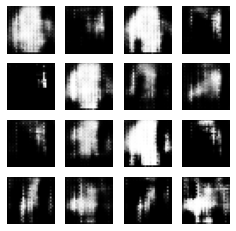

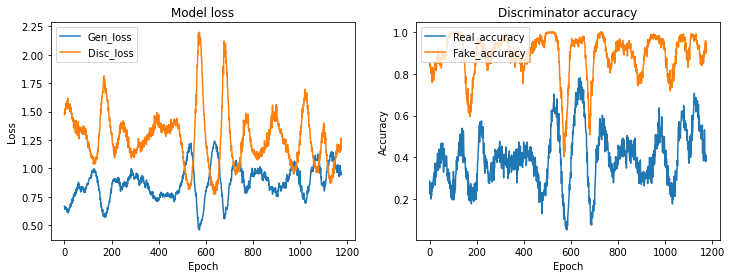

Epoch 5 time for one epoch : 12 sec
Epoch 6 [0/235] gen_loss = 0.9420, disc_loss = 1.1799, real_accuracy = 0.4297, fake_accuracy = 0.9531
Epoch 6 [50/235] gen_loss = 0.9647, disc_loss = 1.2328, real_accuracy = 0.3477, fake_accuracy = 0.9180
Epoch 6 [100/235] gen_loss = 0.8552, disc_loss = 1.1632, real_accuracy = 0.4883, fake_accuracy = 0.8828
Epoch 6 [150/235] gen_loss = 1.0591, disc_loss = 1.0785, real_accuracy = 0.5039, fake_accuracy = 0.9141
Epoch 6 [200/235] gen_loss = 0.8167, disc_loss = 1.3055, real_accuracy = 0.3438, fake_accuracy = 0.8984
Epoch 6 time for one epoch : 11 sec
Epoch 7 [0/235] gen_loss = 0.9556, disc_loss = 1.1628, real_accuracy = 0.5078, fake_accuracy = 0.9492
Epoch 7 [50/235] gen_loss = 0.7905, disc_loss = 1.5104, real_accuracy = 0.3047, fake_accuracy = 0.8242
Epoch 7 [100/235] gen_loss = 1.2738, disc_loss = 0.8192, real_accuracy = 0.6055, fake_accuracy = 0.9922
Epoch 7 [150/235] gen_loss = 0.8575, disc_loss = 1.4456, real_accuracy = 0.4141, fake_accuracy = 0.820

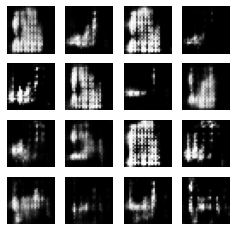

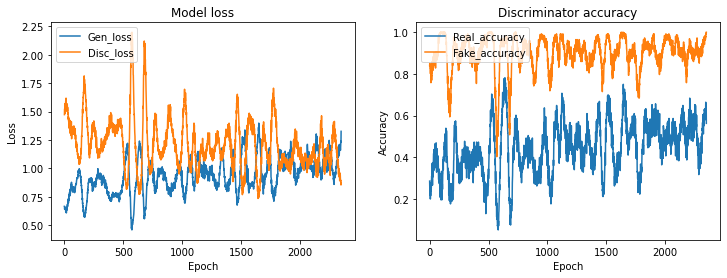

Epoch 10 time for one epoch : 12 sec
Epoch 11 [0/235] gen_loss = 1.3237, disc_loss = 0.7777, real_accuracy = 0.6953, fake_accuracy = 0.9883
Epoch 11 [50/235] gen_loss = 1.1126, disc_loss = 1.3141, real_accuracy = 0.5117, fake_accuracy = 0.8438
Epoch 11 [100/235] gen_loss = 1.5751, disc_loss = 0.7125, real_accuracy = 0.7227, fake_accuracy = 0.9375
Epoch 11 [150/235] gen_loss = 1.2049, disc_loss = 1.0856, real_accuracy = 0.5859, fake_accuracy = 0.8359
Epoch 11 [200/235] gen_loss = 1.1462, disc_loss = 0.9364, real_accuracy = 0.6094, fake_accuracy = 0.9258
Epoch 11 time for one epoch : 11 sec
Epoch 12 [0/235] gen_loss = 1.0949, disc_loss = 1.1180, real_accuracy = 0.4414, fake_accuracy = 0.9453
Epoch 12 [50/235] gen_loss = 1.3136, disc_loss = 0.8467, real_accuracy = 0.6562, fake_accuracy = 0.9609
Epoch 12 [100/235] gen_loss = 1.4013, disc_loss = 0.9646, real_accuracy = 0.6016, fake_accuracy = 0.9492
Epoch 12 [150/235] gen_loss = 1.1236, disc_loss = 1.0040, real_accuracy = 0.6211, fake_accur

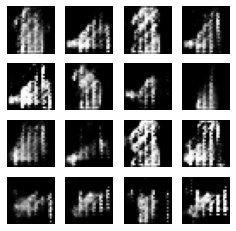

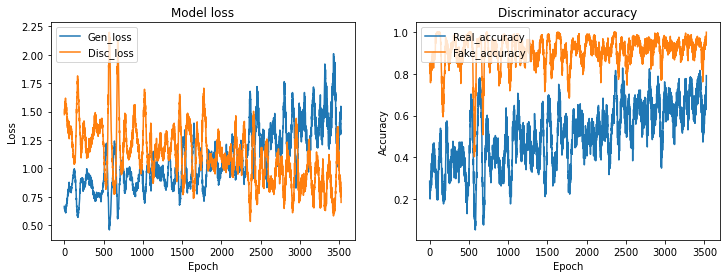

Epoch 15 time for one epoch : 12 sec
Epoch 16 [0/235] gen_loss = 1.3219, disc_loss = 0.7581, real_accuracy = 0.7578, fake_accuracy = 0.9336
Epoch 16 [50/235] gen_loss = 1.7136, disc_loss = 0.6550, real_accuracy = 0.7461, fake_accuracy = 0.9805
Epoch 16 [100/235] gen_loss = 1.4585, disc_loss = 1.0273, real_accuracy = 0.5547, fake_accuracy = 0.9297
Epoch 16 [150/235] gen_loss = 1.2754, disc_loss = 0.9074, real_accuracy = 0.7031, fake_accuracy = 0.8750
Epoch 16 [200/235] gen_loss = 1.3390, disc_loss = 0.9523, real_accuracy = 0.6758, fake_accuracy = 0.8750
Epoch 16 time for one epoch : 11 sec
Epoch 17 [0/235] gen_loss = 1.4426, disc_loss = 0.9665, real_accuracy = 0.5977, fake_accuracy = 0.9062
Epoch 17 [50/235] gen_loss = 1.5677, disc_loss = 0.7205, real_accuracy = 0.7266, fake_accuracy = 0.9805
Epoch 17 [100/235] gen_loss = 1.6362, disc_loss = 0.8336, real_accuracy = 0.6250, fake_accuracy = 0.9609
Epoch 17 [150/235] gen_loss = 1.6773, disc_loss = 0.7321, real_accuracy = 0.6719, fake_accur

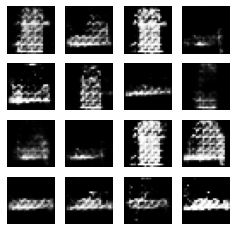

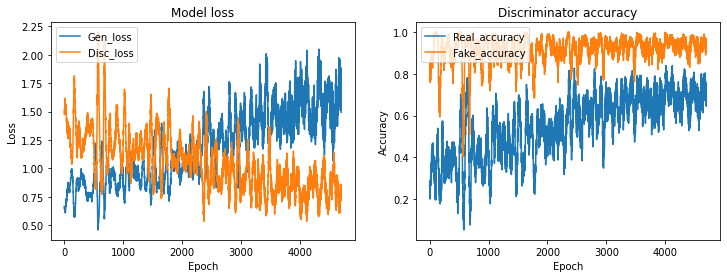

Epoch 20 time for one epoch : 12 sec
Epoch 21 [0/235] gen_loss = 1.5918, disc_loss = 0.7783, real_accuracy = 0.7148, fake_accuracy = 0.9062
Epoch 21 [50/235] gen_loss = 2.0259, disc_loss = 0.6191, real_accuracy = 0.7578, fake_accuracy = 0.9570
Epoch 21 [100/235] gen_loss = 1.4365, disc_loss = 0.9706, real_accuracy = 0.6445, fake_accuracy = 0.8750
Epoch 21 [150/235] gen_loss = 1.7461, disc_loss = 0.6843, real_accuracy = 0.7305, fake_accuracy = 0.9805
Epoch 21 [200/235] gen_loss = 1.8090, disc_loss = 0.6172, real_accuracy = 0.7656, fake_accuracy = 0.9453
Epoch 21 time for one epoch : 11 sec
Epoch 22 [0/235] gen_loss = 1.7896, disc_loss = 0.9380, real_accuracy = 0.6406, fake_accuracy = 0.9453
Epoch 22 [50/235] gen_loss = 1.5463, disc_loss = 1.0139, real_accuracy = 0.5820, fake_accuracy = 0.8945
Epoch 22 [100/235] gen_loss = 1.5085, disc_loss = 0.8968, real_accuracy = 0.6367, fake_accuracy = 0.9453
Epoch 22 [150/235] gen_loss = 1.5504, disc_loss = 0.7773, real_accuracy = 0.7344, fake_accur

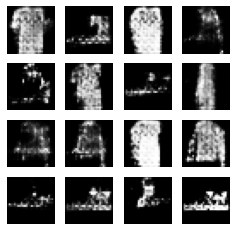

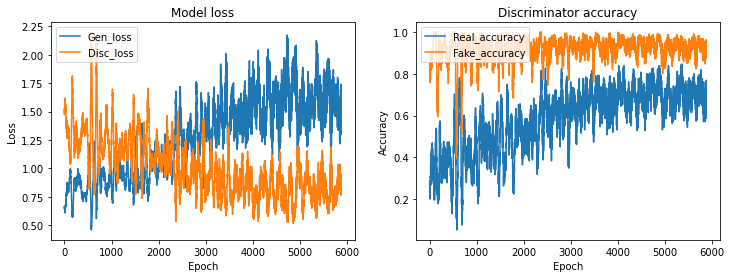

Epoch 25 time for one epoch : 12 sec
Epoch 26 [0/235] gen_loss = 1.6260, disc_loss = 0.8741, real_accuracy = 0.6367, fake_accuracy = 0.9336
Epoch 26 [50/235] gen_loss = 1.7192, disc_loss = 0.7418, real_accuracy = 0.7461, fake_accuracy = 0.9219
Epoch 26 [100/235] gen_loss = 1.3554, disc_loss = 0.8829, real_accuracy = 0.7148, fake_accuracy = 0.8867
Epoch 26 [150/235] gen_loss = 1.6568, disc_loss = 0.7867, real_accuracy = 0.7148, fake_accuracy = 0.9141
Epoch 26 [200/235] gen_loss = 1.5058, disc_loss = 0.8466, real_accuracy = 0.6914, fake_accuracy = 0.9062
Epoch 26 time for one epoch : 11 sec
Epoch 27 [0/235] gen_loss = 1.5752, disc_loss = 0.7185, real_accuracy = 0.7422, fake_accuracy = 0.9414
Epoch 27 [50/235] gen_loss = 1.5004, disc_loss = 0.8310, real_accuracy = 0.7109, fake_accuracy = 0.9297
Epoch 27 [100/235] gen_loss = 1.6530, disc_loss = 0.9049, real_accuracy = 0.6172, fake_accuracy = 0.9062
Epoch 27 [150/235] gen_loss = 1.3572, disc_loss = 0.8841, real_accuracy = 0.7461, fake_accur

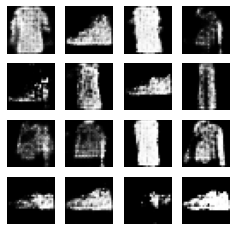

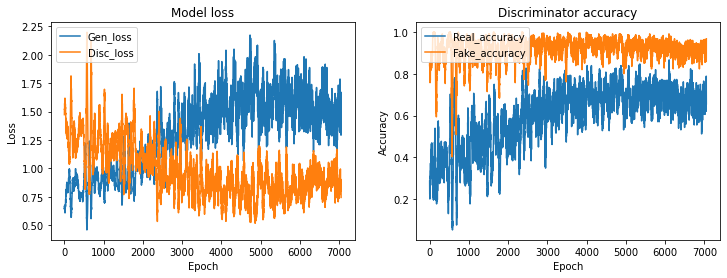

Epoch 30 time for one epoch : 12 sec
Epoch 31 [0/235] gen_loss = 1.7366, disc_loss = 0.8392, real_accuracy = 0.6289, fake_accuracy = 0.9531
Epoch 31 [50/235] gen_loss = 1.3525, disc_loss = 0.9482, real_accuracy = 0.6758, fake_accuracy = 0.9023
Epoch 31 [100/235] gen_loss = 1.6858, disc_loss = 0.7975, real_accuracy = 0.6680, fake_accuracy = 0.9648
Epoch 31 [150/235] gen_loss = 1.2606, disc_loss = 1.0121, real_accuracy = 0.6719, fake_accuracy = 0.8359
Epoch 31 [200/235] gen_loss = 1.6637, disc_loss = 0.7833, real_accuracy = 0.6836, fake_accuracy = 0.9531
Epoch 31 time for one epoch : 11 sec
Epoch 32 [0/235] gen_loss = 1.4483, disc_loss = 1.0204, real_accuracy = 0.5977, fake_accuracy = 0.9102
Epoch 32 [50/235] gen_loss = 1.3526, disc_loss = 0.9085, real_accuracy = 0.6680, fake_accuracy = 0.9297
Epoch 32 [100/235] gen_loss = 1.4115, disc_loss = 0.9110, real_accuracy = 0.7031, fake_accuracy = 0.8945
Epoch 32 [150/235] gen_loss = 1.3522, disc_loss = 0.9292, real_accuracy = 0.6875, fake_accur

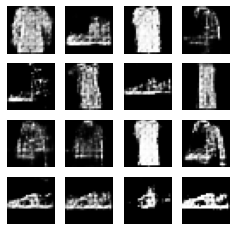

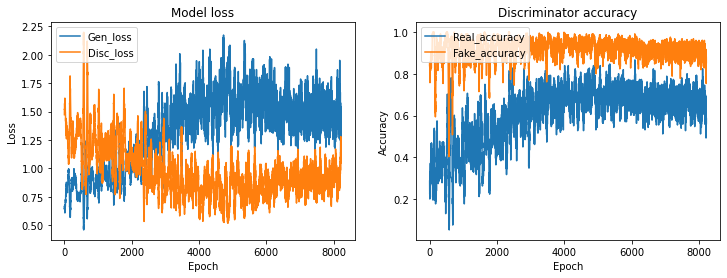

Epoch 35 time for one epoch : 12 sec
Epoch 36 [0/235] gen_loss = 1.2380, disc_loss = 1.1228, real_accuracy = 0.6055, fake_accuracy = 0.8398
Epoch 36 [50/235] gen_loss = 1.5963, disc_loss = 1.0586, real_accuracy = 0.5586, fake_accuracy = 0.9180
Epoch 36 [100/235] gen_loss = 1.6751, disc_loss = 0.7443, real_accuracy = 0.7148, fake_accuracy = 0.9414
Epoch 36 [150/235] gen_loss = 1.4723, disc_loss = 0.8393, real_accuracy = 0.6797, fake_accuracy = 0.8789
Epoch 36 [200/235] gen_loss = 1.4347, disc_loss = 0.9459, real_accuracy = 0.6211, fake_accuracy = 0.9102
Epoch 36 time for one epoch : 11 sec
Epoch 37 [0/235] gen_loss = 1.5146, disc_loss = 0.9923, real_accuracy = 0.6211, fake_accuracy = 0.8945
Epoch 37 [50/235] gen_loss = 1.4035, disc_loss = 0.9396, real_accuracy = 0.6641, fake_accuracy = 0.9102
Epoch 37 [100/235] gen_loss = 1.7757, disc_loss = 0.8795, real_accuracy = 0.6016, fake_accuracy = 0.9453
Epoch 37 [150/235] gen_loss = 1.7742, disc_loss = 0.8506, real_accuracy = 0.5859, fake_accur

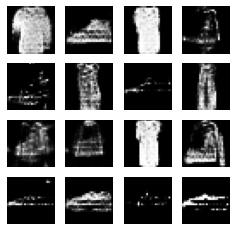

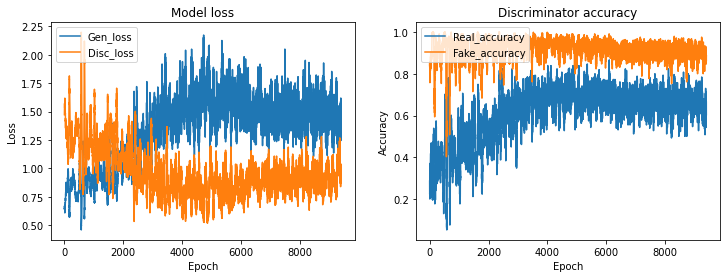

Epoch 40 time for one epoch : 12 sec
Epoch 41 [0/235] gen_loss = 1.2879, disc_loss = 0.9442, real_accuracy = 0.6992, fake_accuracy = 0.8633
Epoch 41 [50/235] gen_loss = 1.2817, disc_loss = 0.9026, real_accuracy = 0.7539, fake_accuracy = 0.8438
Epoch 41 [100/235] gen_loss = 1.2815, disc_loss = 0.9445, real_accuracy = 0.6758, fake_accuracy = 0.8594
Epoch 41 [150/235] gen_loss = 1.7424, disc_loss = 0.7607, real_accuracy = 0.6836, fake_accuracy = 0.9570
Epoch 41 [200/235] gen_loss = 1.4537, disc_loss = 0.8810, real_accuracy = 0.6758, fake_accuracy = 0.9023
Epoch 41 time for one epoch : 11 sec
Epoch 42 [0/235] gen_loss = 1.3295, disc_loss = 1.1327, real_accuracy = 0.5391, fake_accuracy = 0.8672
Epoch 42 [50/235] gen_loss = 1.4715, disc_loss = 0.8895, real_accuracy = 0.6484, fake_accuracy = 0.9297
Epoch 42 [100/235] gen_loss = 1.5019, disc_loss = 0.9462, real_accuracy = 0.6992, fake_accuracy = 0.9062
Epoch 42 [150/235] gen_loss = 1.5362, disc_loss = 0.9766, real_accuracy = 0.6328, fake_accur

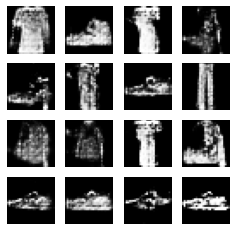

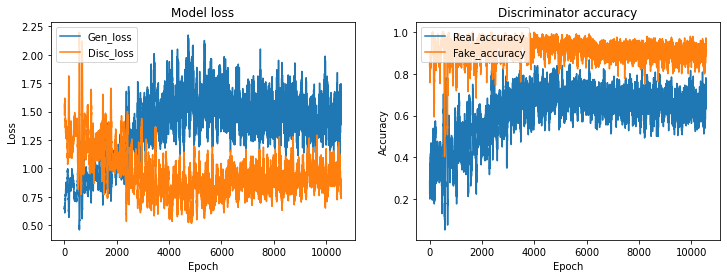

Epoch 45 time for one epoch : 12 sec
Epoch 46 [0/235] gen_loss = 1.7077, disc_loss = 0.7857, real_accuracy = 0.6875, fake_accuracy = 0.9414
Epoch 46 [50/235] gen_loss = 1.7017, disc_loss = 0.9335, real_accuracy = 0.5977, fake_accuracy = 0.9492
Epoch 46 [100/235] gen_loss = 1.5397, disc_loss = 1.1297, real_accuracy = 0.5312, fake_accuracy = 0.8828
Epoch 46 [150/235] gen_loss = 1.5232, disc_loss = 0.9739, real_accuracy = 0.5469, fake_accuracy = 0.9414
Epoch 46 [200/235] gen_loss = 1.3761, disc_loss = 0.9907, real_accuracy = 0.6641, fake_accuracy = 0.9023
Epoch 46 time for one epoch : 11 sec
Epoch 47 [0/235] gen_loss = 1.5679, disc_loss = 0.8746, real_accuracy = 0.6953, fake_accuracy = 0.9102
Epoch 47 [50/235] gen_loss = 1.4753, disc_loss = 1.1442, real_accuracy = 0.5430, fake_accuracy = 0.8906
Epoch 47 [100/235] gen_loss = 1.5524, disc_loss = 0.8445, real_accuracy = 0.6875, fake_accuracy = 0.8906
Epoch 47 [150/235] gen_loss = 1.6051, disc_loss = 0.7152, real_accuracy = 0.7266, fake_accur

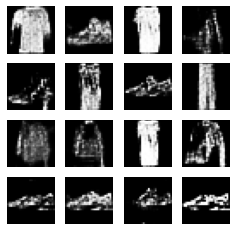

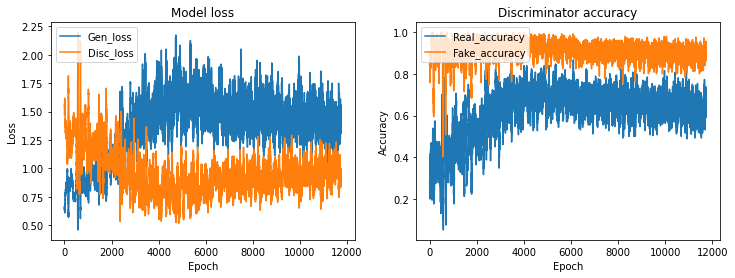

Epoch 50 time for one epoch : 12 sec
Total training time : 571 sec
Total training time: 571.7999057769775 seconds


In [34]:
import time
import tensorflow as tf
import os
import matplotlib.pyplot as plt

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    # 디렉토리 존재 확인 및 생성
    generated_samples_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'dcgan_newimage', 'fashion', 'generated_samples')
    training_history_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'dcgan_newimage', 'fashion', 'training_history')

    if not os.path.exists(generated_samples_dir):
        os.makedirs(generated_samples_dir)
    if not os.path.exists(training_history_dir):
        os.makedirs(training_history_dir)


    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                print ('\rEpoch {} [{}/{}] gen_loss = {:.4f}, disc_loss = {:.4f}, real_accuracy = {:.4f}, fake_accuracy = {:.4f}'
                       .format(epoch+1, it, len(dataset), gen_loss, disc_loss, real_accuracy, fake_accuracy))

        if (epoch + 1) % save_every == 0:
            generate_and_save_images(generator, epoch + 1, it + 1, seed)
            draw_train_history(history, epoch + 1)
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Epoch {} time for one epoch : {} sec'.format(epoch+1, int(time.time()- epoch_start)))
    print ('Total training time : {} sec'.format(int(time.time() - start)))
    return history

def generate_and_save_images(model, epoch, it, seed):
    predictions = model(seed, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()


def draw_train_history(history, epoch):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Gen_loss', 'Disc_loss'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'])
    plt.plot(history['fake_accuracy'])
    plt.title('Discriminator accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Real_accuracy', 'Fake_accuracy'], loc='upper left')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

save_every = 5
EPOCHS = 50

# GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

# 학습 시작 시간 기록
start_time = time.time()

history = train(train_dataset, EPOCHS, save_every)

# 학습 종료 시간 기록 및 실행 시간 계산
end_time = time.time()
execution_time = end_time - start_time

print("Total training time:", execution_time, "seconds")

**코드 설명:**

1.  **`train(dataset, epochs, save_every)` 함수 정의:**
    *   `dataset`: 학습 데이터셋 (tf.data.Dataset 객체)
    *   `epochs`: 전체 학습 횟수
    *   `save_every`: 몇 번의 Epoch마다 결과를 저장할지 결정
2.  **학습 루프:**
    *   `for epoch in range(epochs)`: 전체 데이터셋을 `epochs` 횟수만큼 반복 학습
    *   `for it, image_batch in enumerate(dataset)`: 데이터셋에서 배치 크기만큼 이미지를 가져와 학습
    *   `gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)`: `train_step` 함수를 호출하여 한 단계 학습 진행
    *   **학습 결과 출력:** 50 iteration마다 손실과 정확도를 출력하여 학습 상황을 모니터링
    *   **결과 저장:** `save_every` 간격으로 샘플 이미지 생성, 학습 이력 시각화, 모델 체크포인트 저장
3.  **GPU 디바이스 확인:** `tf.config.list_physical_devices("GPU")`를 사용하여 GPU 사용 가능 여부 확인

### 2. 학습 진행 상황 모니터링

학습 과정에서 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(`fake_accuracy`)가 계속 1에 가깝게 유지된다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 의미입니다.

*   **Fake Accuracy가 1에 가깝다면:**
    *   더 많은 epoch으로 학습을 진행하여 생성자가 더 나은 이미지를 생성하도록 유도합니다.
    *   모델 구조나 학습 방법을 변경하여 생성자와 판별자의 학습 균형을 맞추도록 시도합니다.
    *   학습률(learning rate)을 조정하여 학습 속도를 조절합니다.

### 3. 학습 결과 시각화

In [35]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

print("GIF 파일 생성 완료: {}".format(anim_file))

GIF 파일 생성 완료: /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


**코드 설명:**

1.  **GIF 파일 생성 경로 설정:** GIF 파일이 저장될 경로를 설정합니다.
2.  **imageio.get_writer()**: imageio 라이브러리의 `get_writer`를 활용하여 GIF 파일을 생성합니다.
3.  **샘플 이미지 파일 목록 가져오기:** `glob` 모듈을 사용하여 생성된 샘플 이미지 파일 목록을 가져옵니다.
4.  **이미지 파일 정렬:** 파일 이름을 기준으로 샘플 이미지 파일을 정렬합니다.
5.  **이미지 추가:** 각 이미지를 읽어 GIF 파일에 순차적으로 추가합니다. `append_data` 함수를 사용하여 이미지를 GIF 파일에 추가합니다.

### 4. 학습 결과 확인

생성된 GIF 파일을 통해 생성자가 만들어내는 이미지의 품질이 점점 개선되어 가는 과정을 한 눈에 확인할 수 있습니다.

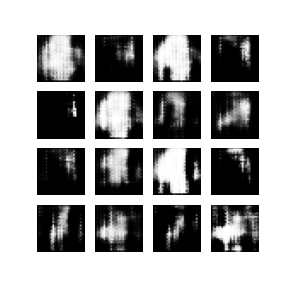

In [36]:
from IPython.display import Image

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

Image(anim_file)